In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
TRAIN_IMG_FOLDER_PATH = '/kaggle/input/intel-image-classification/seg_train/seg_train/'
VAL_IMG_FOLDER_PATH ='/kaggle/input/intel-image-classification/seg_test/seg_test/'

LR = 1e-4
BATCH_SIZE = 32
EPOCHS = 20

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_NAME = 'vit_base_patch16_224.augreg2_in21k_ft_in1k'

In [3]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T


In [4]:
train_augs = T.Compose([
              T.Resize((224,224)),
              T.RandomHorizontalFlip(p=0.5),
              T.RandomRotation(degrees = (-35,+35)),
              T.ToTensor(),
              T.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
])

valid_augs = T.Compose([
             T.Resize((224,224)),
             T.ToTensor(),      # converts to c,h,w
             T.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
])


In [5]:
trainset = ImageFolder(TRAIN_IMG_FOLDER_PATH,transform = train_augs)
validset = ImageFolder(VAL_IMG_FOLDER_PATH,transform = valid_augs)

In [6]:
print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in validset : {len(validset)}")

Total no. of examples in trainset : 14034
Total no. of examples in validset : 3000


In [7]:
print(trainset.class_to_idx)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


(-0.5, 223.5, 223.5, -0.5)

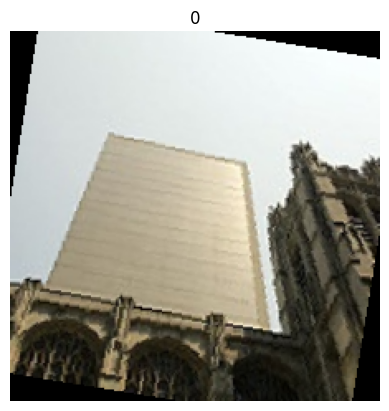

In [8]:
image,label = trainset[40]
plt.imshow(image.permute(1,2,0))
plt.title(label)
plt.axis('off')

In [9]:
from torch.utils.data import DataLoader

In [10]:
trainloader = DataLoader(trainset,batch_size = BATCH_SIZE,shuffle = True)
validloader = DataLoader(validset,batch_size = BATCH_SIZE)

In [11]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 439
Total no. of batches in validloader : 94


In [12]:
for images,labels in trainloader:
    break;

print(f"One image batch shape : {images.shape}")
print(f"One label batch shape : {labels.shape}")

One image batch shape : torch.Size([32, 3, 224, 224])
One label batch shape : torch.Size([32])


In [13]:
import timm
from torch import nn

In [14]:
class ViTModel(nn.Module):
    def __init__(self) :
         super(ViTModel,self).__init__()
        
         self.vit = timm.create_model(MODEL_NAME, pretrained = True, num_classes = 6)
         
    def forward(self,images,labels = None):
        logits = self.vit(images)
        if labels !=None:
            loss = nn.CrossEntropyLoss()(logits,labels)
            return logits,loss
        return logits


In [15]:
model = ViTModel()
model.to(DEVICE);
#model = nn.DataParallel(model)

In [16]:
from tqdm import tqdm

In [17]:
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [18]:
def train_fn(model,dataloader,optimizer,current_epo):
    model.train()
    total_loss =0.0
    total_acc =0.0
    tk =tqdm(dataloader,desc = "EPOCH" + "[Train]"+str(current_epo +1)+ "/"+str(EPOCHS))

    for t,data in enumerate(tk):
        images,labels = data
        # Move images and labels to the same device as the model
        images,labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        logits,loss = model(images,labels)
        loss.backward()
        optimizer.step()

        total_loss+= loss.item()
        total_acc += multiclass_accuracy(logits,labels)
        tk.set_postfix({'loss':'%6f'%float(total_loss / (t+1)),'acc':'%6f'%float(total_acc / (t+1))})
    return total_loss/len(dataloader), total_acc/len(dataloader)

In [19]:
def eval_fn(model,dataloader,current_epo):
    model.eval()
    total_loss =0.0
    total_acc =0.0
    tk =tqdm(dataloader,desc = "EPOCH" + "[val]"+str(current_epo +1)+ "/"+str(EPOCHS))

    for t,data in enumerate(tk):
        images,labels = data
        # Move images and labels to the same device as the model
        images,labels = images.to(DEVICE), labels.to(DEVICE)
        logits,loss = model(images,labels)
        total_loss+= loss.item()
        total_acc += multiclass_accuracy(logits,labels)
        tk.set_postfix({'loss':'%6f'%float(total_loss / (t+1)),'acc':'%6f'%float(total_acc / (t+1))})
    return total_loss/len(dataloader), total_acc/len(dataloader)

In [20]:
optimizer = torch.optim.Adam(model.parameters(),lr = LR)

In [21]:
model.to(DEVICE)
best_valid_loss = np.Inf

for i in range(EPOCHS):
    train_loss,train_acc = train_fn(model,trainloader,optimizer,i)
    valid_loss,valid_acc = eval_fn(model,validloader,i)
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(),'best_weights.pt')
        print('SAVED BEST WEIGHTS')
        best_valid_loss = valid_loss

EPOCH[val]1/20: 100%|██████████| 94/94 [00:56<00:00,  1.67it/s, loss=0.216653, acc=0.923426]


SAVED BEST WEIGHTS


EPOCH[val]3/20: 100%|██████████| 94/94 [00:42<00:00,  2.22it/s, loss=0.203481, acc=0.925864]


SAVED BEST WEIGHTS


EPOCH[Train]11/20:  43%|████▎     | 187/439 [03:41<04:58,  1.18s/it, loss=0.094914, acc=0.969753]


KeyboardInterrupt: 

In [22]:
def view_classify(img, ps):
    classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
    ps = ps.data.cpu().numpy().squeeze()
    preds = classes[np.argmax(ps)]
    img = img.numpy().transpose(1,2,0)
    fig, (ax1, ax2) = plt.subplots(figsize=(5,9), ncols=2)
    ax1.imshow(img)
    ax1.set_title(preds)
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()
    return None

In [23]:
model.load_state_dict(torch.load('/kaggle/working/best_weights.pt'))
model.eval();

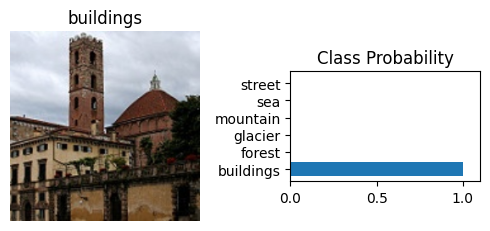

In [25]:
idx = 2
image,label = validset[idx]
image = image.unsqueeze(0)
logits = model(image.to(DEVICE))
probs = nn.Softmax(dim =1)(logits)
view_classify(image.squeeze(),probs)